In [58]:
print('Importing packages...')
import os
import pandas
import numpy as np
import time
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import geopandas
from shapely.geometry import Point
import scipy.stats
from IPython.display import display, HTML
pandas.set_option('display.max_colwidth', -1)
debug = 1
g = 0

# ANALYSIS OPTIONS
jobs_lower_limit = 10
pop_lower_limit = 1000

# MAPPING OPTIONS
scale = 0.25
thecolormap = 'viridis'
show_tract_labels = False#True
show_plot_labels = True

thisdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
#data_dir = '/home/idies/workspace/Temporary/raddick/cra_scratch_final/'
baltimore_dir = thisdir + 'baltimore/'
shapefile_basedir = '/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/'
census_shapefile_tiger_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/'

figdir = thisdir + 'figures/'
mapdir = thisdir + 'maps/'

os.chdir(thisdir)
print('Now in directory: {0:}'.format(os.getcwd()))
print('ok')

Importing packages...
Now in directory: /home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act
ok


In [2]:
s = time.time()
df = pandas.read_csv(baltimore_dir+'baltimore_alldata.csv', encoding='utf-8', index_col=['census_tract', 'activity_year'])
e = time.time()
g = g + (e-s)
df_bk = df
print('read {0:,.0f} rows in {1:,.3f} seconds!'.format(len(df), e-s))

read 1,388 rows in 0.120 seconds!


# How many business loans each year in Baltimore City?

## Define DataFrame for aggregated loans by year

In [3]:
#df.reset_index().columns.tolist()
#df.groupby('action_taken_type').size()
s = time.time()
year_columns = ['nLoans1','nLoans100k','nLoans250k','nLoansToSmallest']
year_columns += ['nLoans','nWorkingLoans']
year_columns += ['nLoans1_per_totaljob','nLoans100k_per_totaljob']
year_columns += ['nLoans250k_per_totaljob','nLoansToSmallest_per_totaljob']
year_columns += ['nLoans_per_totaljob','nWorkingLoans_per_totaljob']
year_columns += ['nLoans1_per_sbjob','nLoans100k_per_sbjob','nLoans250k_per_sbjob']
year_columns += ['nLoansToSmallest_per_sbjob','nLoans_per_sbjob','nWorkingLoans_per_sbjob']
year_columns += ['amtLoans1_adj','amtLoans100k_adj', 'amtLoans250k_adj']
year_columns += ['amtLoansToSmallest_adj','amtLoans_adj', 'amtWorkingLoans_adj']
year_columns += ['amtLoans1_per_totaljob_adj','amtLoans100k_per_totaljob_adj']
year_columns += ['amtLoans250k_per_totaljob_adj','amtLoansToSmallest_per_totaljob_adj']
year_columns += ['amtLoans_per_totaljob_adj','amtWorkingLoans_per_totaljob_adj']
year_columns += ['amtLoans1_per_sbjob_adj','amtLoans100k_per_sbjob_adj']
year_columns += ['amtLoans250k_per_sbjob_adj','amtLoansToSmallest_per_sbjob_adj']
year_columns += ['amtLoans_per_sbjob_adj','amtWorkingLoans_per_sbjob_adj']

years_df = df.reset_index().groupby('activity_year')[year_columns].sum()

e = time.time()
g = g + (e-s)
print('Defined {0:,.0f} years in {1:,.3f} seconds!'.format(len(years_df), e-s))


Defined 7 years in 0.019 seconds!


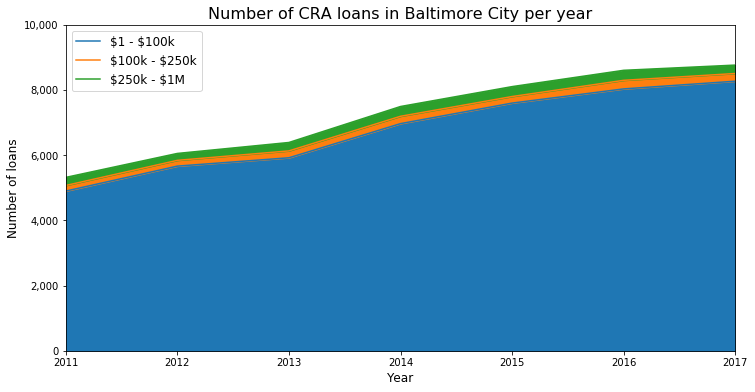

In [4]:
fig, ax1 = plt.subplots(1,1, figsize=(12,6))
years_df[['nLoans1', 'nLoans100k', 'nLoans250k']].plot.area(ax=ax1)
plt.xlim([2011, 2017])
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of loans', fontsize=12)

plt.xticks(np.arange(2011,2018))
yticks = np.arange(0,12000,2000)
ylabels = ['{0:,.0f}'.format(y) for y in yticks]
plt.yticks(yticks, ylabels)

plt.legend(["\$1 - \$100k", "\$100k - \$250k", "\$250k - \$1M"], fontsize=12)
plt.title('Number of CRA loans in Baltimore City per year', fontsize=16)

#plt.savefig(figdir+'nLoans_per_year.jpg', format='jpg')
#print('Done!')
plt.show()

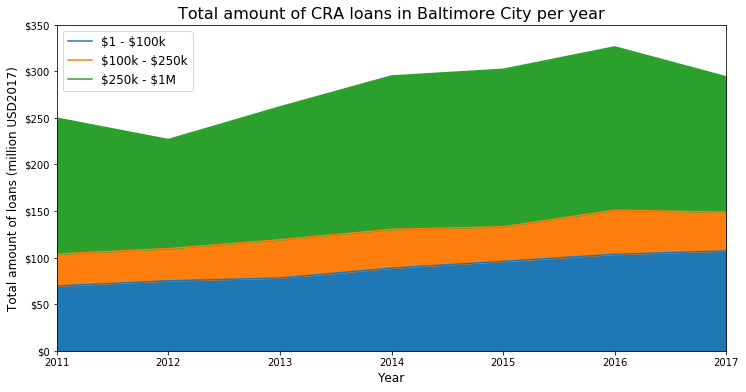

In [5]:
fig, ax2 = plt.subplots(1,1, figsize=(12,6))
years_df[['amtLoans1_adj', 'amtLoans100k_adj', 'amtLoans250k_adj']].plot.area(ax=ax2)
plt.xlim([2011, 2017])
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total amount of loans (million USD2017)', fontsize=12)

plt.xticks(np.arange(2011,2018))
yticks = np.arange(0,400000000,50000000)
ylabels = ['${0:,.0f}'.format(y/1000000) for y in yticks]
plt.yticks(yticks, ylabels)

plt.legend(["\$1 - \$100k", "\$100k - \$250k", "\$250k - \$1M"], fontsize=12)
plt.title('Total amount of CRA loans in Baltimore City per year', fontsize=16)

#plt.savefig(figdir+'nLoans_per_year.jpg', format='jpg')
#print('Done!')
plt.show()

# How much money was loaned in each census tract

To smooth out year-to-year variations, look at the total number/amount of loans for all years from 2011 to 2017, aggregated

In [6]:
print('Summing loans across all years for each tract...')
tract_columns = ['nLoans1','nLoans100k','nLoans250k','nLoansToSmallest']
tract_columns += ['nLoans','nWorkingLoans']
tract_columns += ['nLoans1_per_totaljob','nLoans100k_per_totaljob']
tract_columns += ['nLoans250k_per_totaljob','nLoansToSmallest_per_totaljob']
tract_columns += ['nLoans_per_totaljob','nWorkingLoans_per_totaljob']
tract_columns += ['nLoans1_per_sbjob','nLoans100k_per_sbjob','nLoans250k_per_sbjob']
tract_columns += ['nLoansToSmallest_per_sbjob','nLoans_per_sbjob','nWorkingLoans_per_sbjob']
tract_columns += ['amtLoans1_adj','amtLoans100k_adj', 'amtLoans250k_adj']
tract_columns += ['amtLoansToSmallest_adj','amtLoans_adj', 'amtWorkingLoans_adj']
tract_columns += ['amtLoans1_per_totaljob_adj','amtLoans100k_per_totaljob_adj']
tract_columns += ['amtLoans250k_per_totaljob_adj','amtLoansToSmallest_per_totaljob_adj']
tract_columns += ['amtLoans_per_totaljob_adj','amtWorkingLoans_per_totaljob_adj']
tract_columns += ['amtLoans1_per_sbjob_adj','amtLoans100k_per_sbjob_adj']
tract_columns += ['amtLoans250k_per_sbjob_adj','amtLoansToSmallest_per_sbjob_adj']
tract_columns += ['amtLoans_per_sbjob_adj','amtWorkingLoans_per_sbjob_adj']

tracts_df = df.reset_index().groupby('census_tract')[tract_columns].sum()

print('Keeping only tracts that were the same across all years...')
nYears_s = df.reset_index().groupby('census_tract').size()
nYears_s.name = 'nYears'
tracts_df = tracts_df.join(nYears_s)

nTractsTotal = len(tracts_df)
#tracts_df.groupby('nYears').size()
nTracts7years = len(tracts_df[tracts_df['nYears'] == 7])

print('Keeping only tracts with loans every year: {0:,.0f} out of {1:,.0f} total tracts...'.format(nTracts7years, nTractsTotal))
tracts_df = tracts_df[tracts_df['nYears'] == 7]
print('ok')


Summing loans across all years for each tract...
Keeping only tracts that were the same across all years...
Keeping only tracts with loans every year: 187 out of 207 total tracts...
ok


# Join the now-aggregated loan data with what else we know about each tract

## CSAs and 2017 CRA income level groups

In [7]:
print('joining neighborhoods and CRA levels...')
tract_info_2017_df = df.reset_index().set_index('census_tract')[df.reset_index().set_index('census_tract')['activity_year'] == 2017][['CSA2010', 'income_group_code', 'income_group', 'cra_level']]
tract_info_2017_df = tract_info_2017_df.rename(columns={'income_group_code': 'income_group_code_2017', 'income_group': 'income_group_2017', 'cra_level': 'cra_level_2017'})
tracts_df = tracts_df.join(tract_info_2017_df, how='left')
print('Done')

joining neighborhoods and CRA levels...
Done


## 2015 jobs data from LODES WAC

In [8]:
print('reading job data...')
s = time.time()
raw_jobs_df = pandas.read_csv(baltimore_dir+'wac_jobs_df.csv', index_col='rownumber')
e = time.time()
raw_jobs_2015_df = raw_jobs_df[raw_jobs_df['year'] == 2015]
print('Read {0:,.0f} rows in {1:,.0f} seconds!'.format(len(raw_jobs_df), e-s))

print('finding census tracts...')
raw_jobs_2015_df = raw_jobs_2015_df.assign(census_tract = pandas.to_numeric(raw_jobs_2015_df['w_geocode'].apply(lambda x: str(x)[5:9] + '.' + str(x)[9:11]), errors='coerce'))#.drop_duplicates().sort_values()[0:3]
sum_columns = ['census_tract']
sum_columns += [x for x in raw_jobs_df.columns.tolist() if x not in ('w_geocode', 'createdate', 'year')]

print('grouping by census tract...')
jobs_2015_df = raw_jobs_2015_df[sum_columns].groupby('census_tract').sum()

print('joining jobs...')
tracts_df = tracts_df.join(jobs_2015_df[['C000', 'CFS01']], how='left')
tracts_df = tracts_df.rename(columns={'C000': 'total_jobs', 'CFS01': 'sb_jobs'})
print('Done!')


reading job data...


/home/idies/miniconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Read 1,691,314 rows in 13 seconds!
finding census tracts...
grouping by census tract...
joining jobs...
Done!


## 2017 ACS 5-year estimates and margins of error

### Join population count data

In [9]:
#census_columns = ['pop_total', 'total_householders', 'pop_white', 'pop_black']
census_columns = ['pop_total', 'pop_white', 'pop_black']
#census_columns += ['black_householder', 'white_householder', 'owner_occ_housing_units']
census_columns += ['owner_occ_housing_units']
#census_columns += ['mfi_adj', 'female_householder', 'unemployed_16plus', 'poverty_past_12_months']
census_columns += ['mfi_adj', 'unemployed_16plus', 'poverty_past_12_months']
census_columns += ['median_home_value', 'median_year_built', 'labor_force_16plus']
census_columns += ['poverty_status_known', 'hs_grad_25plus', 'pop_25plus']

#census_error_columns = ['pop_total_err', 'total_householders_err', 'pop_white_err', 'pop_black_err']
census_error_columns = ['pop_total_err', 'pop_white_err', 'pop_black_err']
#census_error_columns += ['black_householder_err', 'white_householder_err', 'owner_occ_housing_units_err']
census_error_columns += ['owner_occ_housing_units_err']
#census_error_columns += ['mfi_err', 'female_householder_err', 'total_householder_err', 'unemployed_16plus_err']
census_error_columns += ['mfi_err', 'unemployed_16plus_err']
census_error_columns += ['poverty_past_12_months_err', 'median_home_value_err', 'median_year_built_err']
census_error_columns += ['labor_force_16plus_err', 'poverty_status_known_last12months_total_err']
census_error_columns += ['hs_grad_25plus_serr', 'pop_25plus_serr']

print('joining ACS 5-year estimates and margins of error...')
tracts_acs5_2017 = df.reset_index()[df.reset_index()['activity_year'] == 2017].set_index('census_tract')[census_columns]
tracts_acs5_err_2017 = df.reset_index()[df.reset_index()['activity_year'] == 2017].set_index('census_tract')[census_error_columns]

tracts_df = tracts_df.join(tracts_acs5_2017, how='left')
tracts_df = tracts_df.join(tracts_acs5_err_2017, how='left')

#tracts_df.head(1).T
print('Done!')


joining ACS 5-year estimates and margins of error...
Done!


### Calculate percentages for some variables

For better direct comparison between tracts of different total populations

(get percentage values from estimates, with margins of error expressed in percent)

#### Create function to calculate errors in percentages

In [10]:
#Guide on how to do this:
#### https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018_ch08.pdf

# X and Y are the measured values (not the errors) - X for the subsgroup and Y for the whole sample
# Let P = X/Y  (the proportion we calculated in the last step)
# dX and dY are the measured errors
# dP = (1/Y) * np.sqrt(dX**2 - (P**2 * dY**2))
# Standard error of P is dP/1.645
#### this calculation is done verbosely in fnid_pop_white_serr, quickly in other functions

def find_errors_in_pct(X, Y, dX, dY, verboselevel = 0):
    try:
        P = X / Y
        oneoverY = 1 / Y
        dXsq = dX**2
        dYsq = dY**2
        Psq = P**2
        PsqdYsq = Psq * dYsq
        if (PsqdYsq <= dXsq):
            underroot = dXsq - PsqdYsq
        else:
            underroot = dXsq + PsqdYsq
        rooty = np.sqrt(underroot)
        dP = oneoverY * rooty
        SE = dP / 1.645
        if (verboselevel >= 2):
#            print('X = pop_white, Y = pop_total')
            print('X = {0:.0f}, dX = {1:.0f} ({2:.1%} error)'.format(X, dX, dX/X))
            print('Y = {0:.0f}, dY = {1:.0f} ({2:.1%} error)'.format(Y, dY, dY/Y))
        if (verboselevel >= 3):
            print('P = {0:.3f}'.format(P))
            print('dXsq = {0:.0f}, dYsq = {1:.0f}, Psq = {2:.3f}'.format(dXsq, dYsq, Psq))
            print('PsqdYsq = {0:.0f}, underroot = {1:.0f}, rooty = {2:.3f}'.format(PsqdYsq, underroot, rooty))
            print('dP = {0:.3f}'.format(dP))
            print('SE = {0:.3f}'.format(SE))
        if (verboselevel >= 2):
            print('RESULT: {0:.2%} +/- {1:.2%}'.format(P, SE)) 
            print('\n')
        return pandas.to_numeric(SE, errors='coerce')
    except ZeroDivisionError:
        return np.nan
print('Defined functions to calculate standard errors in percentages!')
print('ok')

Defined functions to calculate standard errors in percentages!
ok


### Calculate percentages and errors in percentages

In [11]:
s = time.time()
verboselevel = 0

print('Calculating percentage values...')

tracts_df = tracts_df.assign(pct_white = tracts_df['pop_white'] / tracts_df['pop_total'])
tracts_df = tracts_df.assign(pct_black = tracts_df['pop_black'] / tracts_df['pop_total'])

tracts_df = tracts_df.assign(pct_hs_grad = tracts_df['hs_grad_25plus'] / tracts_df['pop_25plus'])
tracts_df = tracts_df.assign(pct_unemployed = tracts_df['unemployed_16plus'] / tracts_df['labor_force_16plus'])
tracts_df = tracts_df.assign(pct_poverty = tracts_df['poverty_past_12_months'] / tracts_df['poverty_status_known'])

print('Calculating errors in percentages...')
tracts_df = tracts_df.assign(pct_white_serr = np.nan)
tracts_df = tracts_df.assign(pct_black_serr = np.nan)
#tracts_df = tracts_df.assign(pct_white_householder_serr = np.nan)
#tracts_df = tracts_df.assign(pct_black_householder_serr = np.nan)
#tracts_df = tracts_df.assign(pct_female_householder_serr = np.nan)
tracts_df = tracts_df.assign(pct_hs_grad_serr = np.nan)
tracts_df = tracts_df.assign(pct_unemployed_serr = np.nan)
tracts_df = tracts_df.assign(pct_poverty_serr = np.nan)
tracts_df.loc[:, 
              'poverty_status_known_last12months_total_err'] = pandas.to_numeric(tracts_df['poverty_status_known_last12months_total_err'], errors='coerce')


for ix, thisrow in tracts_df.iterrows():
    if (verboselevel >= 2):
        print('Census tract {0:}...'.format(ix))
    tracts_df.loc[ix, 'pct_white_serr'] = find_errors_in_pct(thisrow['pop_white'], thisrow['pop_total'], thisrow['pop_white_err'], thisrow['pop_total_err'], verboselevel)
    tracts_df.loc[ix, 'pct_black_serr'] = find_errors_in_pct(thisrow['pop_black'], thisrow['pop_total'], thisrow['pop_black_err'], thisrow['pop_total_err'], verboselevel)
    tracts_df.loc[ix, 'pct_hs_grad_serr'] = find_errors_in_pct(thisrow['hs_grad_25plus'], thisrow['pop_25plus'], thisrow['hs_grad_25plus_serr'], thisrow['pop_25plus_serr'], verboselevel)
    tracts_df.loc[ix, 'pct_unemployed_serr'] = find_errors_in_pct(thisrow['unemployed_16plus'], thisrow['labor_force_16plus'], thisrow['hs_grad_25plus_serr'], thisrow['labor_force_16plus_err'], verboselevel)
    tracts_df.loc[ix, 'pct_poverty_serr'] = find_errors_in_pct(thisrow['poverty_past_12_months'], thisrow['poverty_status_known'], thisrow['poverty_past_12_months_err'], thisrow['poverty_status_known_last12months_total_err'], verboselevel)

if (verboselevel >= 1):
    for ix, thisrow in tracts_df.iterrows():
        print('Census tract {0:,.0f}'.format(ix))
        print('{0:,.0f} +/- {1:,.0f} white'.format(
            thisrow['pop_white'], thisrow['pop_white_err']
        ))
        print('{0:,.0f} +/- {1:,.0f} total'.format(
            thisrow['pop_total'], thisrow['pop_total_err']
        ))
        print('{0:.1%} +/- {1:.1%}'.format(
            thisrow['pct_white'], thisrow['pct_white_serr']
        ))
        print('\n')

#tracts_df[
#    ['pop_white', 'pop_total', 'pop_white_err', 'pop_total_err', 'pct_white', 'pct_white_serr']
#]

print('backing up...')
tracts_df_bk = tracts_df

e = time.time()
print('Processed {0:,.0f} rows in {1:,.2f} seconds!'.format(len(tracts_df), e-s))


Calculating percentage values...
Calculating errors in percentages...
backing up...
Processed 187 rows in 1.25 seconds!


# Join shapefiles to produce a mappable GeoDataFrame

## Join 2017 shapefiles for city census tracts

In [12]:
thisyear = 2017

if (debug > 0):
    print('Getting census tract shapefiles for {0:.0f}...'.format(thisyear))
tract_shapes_gdf = geopandas.read_file(census_shapefile_tiger_basedir +'{0:.0f}/TRACT/tl_{0:.0f}_24_tract.shp'.format(thisyear))
tract_shapes_gdf = tract_shapes_gdf[tract_shapes_gdf['COUNTYFP'] == '510']
tract_shapes_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_shapes_gdf['NAME'], errors='coerce')
tract_shapes_gdf = tract_shapes_gdf.assign(census_tract = pandas.to_numeric(tract_shapes_gdf['GEOID'].apply(lambda x: x[5:9]+'.'+x[9:]), errors='coerce'))
tract_shapes_gdf = tract_shapes_gdf.drop('GEOID', axis=1)
tract_shapes_gdf = tract_shapes_gdf.set_index('census_tract')

print('cutting out harbor...')
water_gdf = geopandas.read_file(shapefile_basedir+'water/water.shp')
water_gdf = water_gdf.to_crs(tract_shapes_gdf.crs)

tract_shapes_gdf = geopandas.overlay(tract_shapes_gdf, water_gdf[water_gdf['NAME'] == 'Harbor'], how='difference')

print('joining shapefiles onto data...')
#tracts_df = tracts_df.join(tract_shapes_gdf, how='left')#, lsuffix='_loans', rsuffix='_shapes')#[['GEOID_loans', 'GEOID_shapes']]
tracts_gdf = geopandas.GeoDataFrame(tracts_df.join(tract_shapes_gdf, how='left'), crs=tract_shapes_gdf.crs)

print('backing up geodataframe...')
tracts_gdf_bk = tracts_gdf

print("Done!")
#tracts_df.head(1).T


Getting census tract shapefiles for 2017...
cutting out harbor...
joining shapefiles onto data...
backing up geodataframe...
Done!


# Map of total amount loaned by census tract

Minimum loan amount per small business job: $0
Maximum loan amount per small business job: $194,022 in tract 2503.03
making basic plot...
setting options...
adding colorbar...
Done!


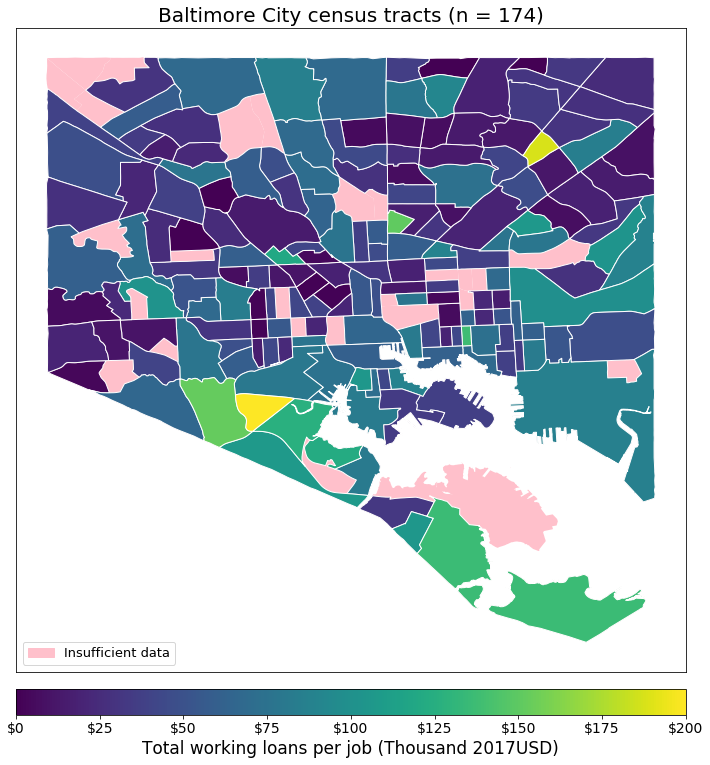

In [13]:
#print('ok')
min_loan = tracts_gdf[
    #(tracts_gdf['cra_level_2017'] != 'unknown')
    (tracts_gdf['sb_jobs'] >= jobs_lower_limit)
    & (tracts_gdf['pop_total'] >= pop_lower_limit)
]['amtWorkingLoans_per_sbjob_adj'].min()
max_loan = tracts_gdf[
    #(tracts_gdf['cra_level_2017'] != 'unknown')
    (tracts_gdf['sb_jobs'] >= jobs_lower_limit)
    & (tracts_gdf['pop_total'] >= pop_lower_limit)
]['amtWorkingLoans_per_sbjob_adj'].max()
idmax_loan = tracts_gdf[
    #(tracts_gdf['cra_level_2017'] != 'unknown')
    (tracts_gdf['sb_jobs'] >= jobs_lower_limit)
    & (tracts_gdf['pop_total'] >= pop_lower_limit)
]['amtWorkingLoans_per_sbjob_adj'].idxmax()

print('Minimum loan amount per small business job: ${0:,.0f}'.format(min_loan))
print('Maximum loan amount per small business job: ${0:,.0f} in tract {1:}'.format(max_loan, idmax_loan))

print('making basic plot...')
fig, ax = plt.subplots(1,1, figsize=(48*scale, 48*scale))
tract_shapes_gdf.plot(ax=ax, color='pink')

tracts_gdf[
    #(tracts_gdf['cra_level_2017'] != 'unknown')
    (tracts_gdf['sb_jobs'] >= jobs_lower_limit)
    & (tracts_gdf['pop_total'] >= pop_lower_limit)
].plot(column='amtWorkingLoans_per_sbjob_adj', ax=ax, cmap=thecolormap, edgecolor='white')

print('setting options...')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.title('Baltimore City census tracts (n = {0:,.0f})'.format(
    len(tracts_gdf[(tracts_gdf['sb_jobs'] >= jobs_lower_limit) & (tracts_gdf['pop_total'] >= pop_lower_limit)])), 
          fontsize=80*scale)

pink_patch = mpatches.Patch(color='pink', label='Insufficient data')
plt.legend(handles=[pink_patch], loc='lower left', fontsize=52*scale)

print('adding colorbar...')
cax = fig.add_axes([0.125, 0.08, 0.775, 0.03])

sm = plt.cm.ScalarMappable(cmap=thecolormap, norm=plt.Normalize(
    vmin=0, 
    vmax=200000
#    vmax=tracts_gdf[(tracts_gdf['sb_jobs'] >= jobs_lower_limit) & (tracts_gdf['pop_total'] >= pop_lower_limit)]['amtWorkingLoans_per_sbjob_adj'].max()
))
## fake up the array of the scalar mappable. Urgh...
sm._A = []

cbar = fig.colorbar(sm, cax=cax, format='$%.0f', 
                    ticks=np.arange(0, 
                                    225000, #tracts_gdf[(tracts_gdf['nYears'] == 7) & (tracts_gdf['sb_jobs'] >= jobs_lower_limit) & (tracts_gdf['pop_total'] >= pop_lower_limit)]['amtWorkingLoans_per_sbjob_adj'].max(), 
                                    25000), 
                    orientation='horizontal')

#cbar.set_ticks(np.arange(0, 225000, 25000))
cax.set_xticklabels(['${:,.0f}'.format(x/1000) for x in np.arange(0, 225000, 25000)], fontsize=56*scale)

cbar.set_label('Total working loans per job (Thousand 2017USD)', fontsize=68*scale)


if (show_tract_labels):
    print('adding tract labels...')
    for ix, thisrow in tracts_gdf.iterrows():
        annotator = str(ix).replace('-', '- ')
        annotator = annotator.replace('/', '/ ')
        annotator = annotator.replace(' ', '\n')
        annotator = annotator.upper()
        if ((thisrow['sb_jobs'] >= jobs_lower_limit) & (thisrow['pop_total'] >= pop_lower_limit)):
            annotator += '\n'
            annotator += '${0:,.0f}k'.format(thisrow['amtWorkingLoans_per_sbjob_adj']/1000)
        ax.annotate(annotator, 
                    xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    backgroundcolor = 'white',
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=24*scale)

plt.savefig(figdir+'map_20190719.svg', format='svg')
#plt.show()
print('Done!')
#tracts_gdf.columns.tolist()

# Plot lending of all tracts, histograms for each CRA level

## As 4 separate histograms

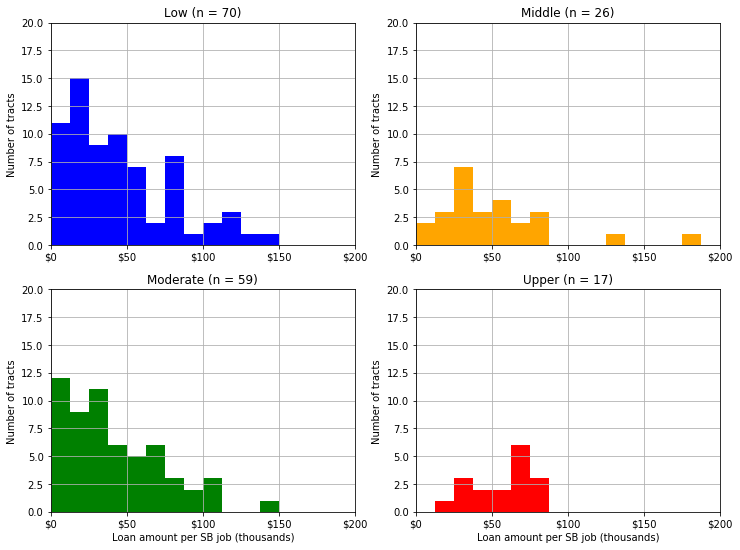

In [14]:
binlist = np.arange(0, 200000, 12500)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(48*scale, 36*scale))

tracts_df[
    (tracts_df['cra_level_2017'] == 'low') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)
]['amtWorkingLoans_per_sbjob_adj'].hist(ax=ax1, color='blue', bins=binlist)
tracts_df[
    (tracts_df['cra_level_2017'] == 'middle') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)
]['amtWorkingLoans_per_sbjob_adj'].hist(ax=ax2, color='orange', bins=binlist)
tracts_df[
    (tracts_df['cra_level_2017'] == 'moderate') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)
]['amtWorkingLoans_per_sbjob_adj'].hist(ax=ax3, color='green', bins=binlist)
tracts_df[
    (tracts_df['cra_level_2017'] == 'upper') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)
]['amtWorkingLoans_per_sbjob_adj'].hist(ax=ax4, color='red', bins=binlist)


for tax in (ax1, ax2, ax3, ax4):
    tax.set_xlim(0, 200000)
    tax.set_ylim(0, 20)
    if (tax in [ax3, ax4]):
        tax.set_xlabel('Loan amount per SB job (thousands)')
    tax.set_ylabel('Number of tracts')
    xticks = np.arange(0,225000,50000)
    xticklabels = ['${0:,.0f}'.format(x/1000) for x in xticks]
    tax.set_xticks(xticks)
    tax.set_xticklabels(xticklabels)#, fontsize=44*scale)

    
ax1.set_title('Low (n = {0:.0f})'.format(len(tracts_df[(tracts_df['cra_level_2017'] == 'low') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)])))
ax2.set_title('Middle (n = {0:.0f})'.format(len(tracts_df[(tracts_df['cra_level_2017'] == 'middle') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)])))
ax3.set_title('Moderate (n = {0:.0f})'.format(len(tracts_df[(tracts_df['cra_level_2017'] == 'moderate') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)])))
ax4.set_title('Upper (n = {0:.0f})'.format(len(tracts_df[(tracts_df['cra_level_2017'] == 'upper') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)])))

plt.show()


## As a stacked histogram

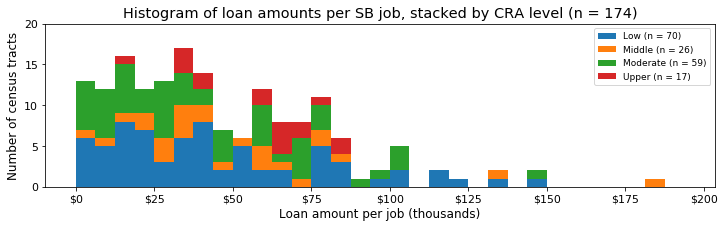

Outliers with more than $125,000 in adjusted loans per job
----------------------------------------------------------
Census tract 2503.03 (moderate, MFI $44k): 71 SB jobs, $194k in loans per SB job
Census tract 2703.02 (middle, MFI $91k): 35 SB jobs, $182k in loans per SB job
Census tract 2502.06 (moderate, MFI $72k): 403 SB jobs, $148k in loans per SB job
Census tract 904.0 (low, MFI $31k): 112 SB jobs, $146k in loans per SB job
Census tract 105.0 (middle, MFI $121k): 53 SB jobs, $133k in loans per SB job
Census tract 2505.0 (low, MFI $44k): 341 SB jobs, $132k in loans per SB job


In [15]:
binlist = np.arange(0, 200000, 6250)

fig, ax1 = plt.subplots(1,1, figsize=(48*scale, 12*scale))

plt.hist([
    tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['cra_level_2017'] == 'low') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)], 
    tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['cra_level_2017'] == 'middle') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)], 
    tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['cra_level_2017'] == 'moderate') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)],      
    tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['cra_level_2017'] == 'upper') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)]
    ],
    bins = binlist,
    stacked = True
)

legendlist = []
legendlist.append('Low (n = {0:.0f})'.format(len(tracts_df[(tracts_df['cra_level_2017'] == 'low') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)])))
legendlist.append('Middle (n = {0:.0f})'.format(len(tracts_df[(tracts_df['cra_level_2017'] == 'middle') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)])))
legendlist.append('Moderate (n = {0:.0f})'.format(len(tracts_df[(tracts_df['cra_level_2017'] == 'moderate') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)])))
legendlist.append('Upper (n = {0:.0f})'.format(len(tracts_df[(tracts_df['cra_level_2017'] == 'upper') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)])))
plt.legend(legendlist, fontsize=36*scale)

plt.xlabel('Loan amount per job (thousands)', fontsize=48*scale)
xticks = np.arange(0, 225000, 25000)
xticklabels = ['${0:,.0f}'.format(x/1000) for x in xticks]
plt.xticks(xticks, xticklabels, fontsize=44*scale)

plt.ylabel('Number of census tracts',fontsize=48*scale)
plt.yticks(np.arange(0, 25, 5), np.arange(0, 25, 5), fontsize=44*scale)

plt.title('Histogram of loan amounts per SB job, stacked by CRA level (n = {0:.0f})'.format(
    len(tracts_df[(tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)])
    ), fontsize=58*scale)
plt.show()

print('Outliers with more than $125,000 in adjusted loans per job')
print('----------------------------------------------------------')
for ix, thisrow in tracts_df[
    (tracts_df['sb_jobs'] >= jobs_lower_limit) 
    & (tracts_df['pop_total'] >= pop_lower_limit)
    & (tracts_df['amtWorkingLoans_per_sbjob_adj'] >= 125000)
][[
 'cra_level_2017',
 'amtWorkingLoans_per_sbjob_adj',
 'sb_jobs',
 'mfi_adj']].sort_values(by='amtWorkingLoans_per_sbjob_adj', ascending=False).iterrows():
    print('Census tract {0:} ({1:}, MFI ${2:,.0f}k): {3:,.0f} SB jobs, ${4:,.0f}k in loans per SB job'.format(
                    ix, 
                    thisrow['cra_level_2017'], 
                    np.round(thisrow['mfi_adj'] / 1000, 0),
                    thisrow['sb_jobs'],
                    np.round(thisrow['amtWorkingLoans_per_sbjob_adj'] / 1000, 0)
                   ))


# Mean lending by CRA level (plot line or bar graph)

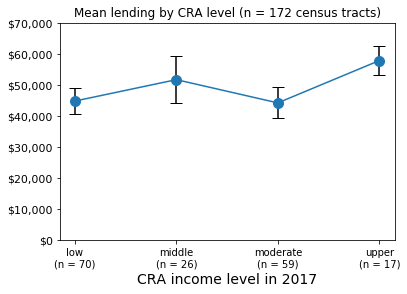

CRA level,Tracts,Mean working loans per SB job,SEM working loans per SB job
low,70,"$44,799","$4,199"
middle,26,"$51,685","$7,531"
moderate,59,"$44,206","$4,965"
upper,17,"$57,823","$4,740"


In [16]:
plot_type = 'line'

cra_level_df = pandas.DataFrame(tracts_df[
    (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
].groupby('cra_level_2017').size(), columns=['nTracts'])

cra_level_df = cra_level_df.assign(mean_working_loans_per_job_adj = tracts_df[
    (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
].groupby('cra_level_2017')['amtWorkingLoans_per_sbjob_adj'].mean())
cra_level_df = cra_level_df.assign(sem_working_loans_per_job_adj = tracts_df[
    (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
].groupby('cra_level_2017')['amtWorkingLoans_per_sbjob_adj'].sem())

cra_level_df = cra_level_df.drop('unknown', axis=0)

fig, ax = plt.subplots(1,1)#, figsize=(48*scale, 36*scale))

label_list = cra_level_df.index.tolist()
for i in range(0, len(label_list)):
    label_list[i] += '\n(n = {0:,.0f})'.format(cra_level_df['nTracts'].loc[label_list[i]])

if (plot_type == 'line'):
    cra_level_df.plot(y='mean_working_loans_per_job_adj', yerr='sem_working_loans_per_job_adj', ax=ax, 
                     marker='.', ms=20, capsize=6, ecolor='black')
    plt.xticks(np.arange(0,4), label_list)
elif (plot_type == 'bar'):
    cra_level_df.plot.bar(y='mean_working_loans_per_job_adj', yerr='sem_working_loans_per_job_adj', ax=ax, 
                     capsize=6, ecolor='black')
    plt.xticks(np.arange(0,4), label_list, rotation='horizontal')
else:
    print('Please select bar or line graph!')
    
plt.xlabel('CRA income level in 2017', fontsize=14)


yticks = np.arange(0,80000,10000)
yticklabels = ['${0:,.0f}'.format(x) for x in yticks]
plt.yticks(yticks, yticklabels, fontsize=44*scale)

ax.get_legend().remove()
plt.title('Mean lending by CRA level (n = {0:.0f} census tracts)'.format(len(tracts_df[
    (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
    & (tracts_df['cra_level_2017'] != 'unknown')
])))
plt.show()

thehtml = '<table>'
thehtml += '<tr><th>CRA level</th><th>Tracts</th><th>Mean working loans per SB job</th><th>SEM working loans per SB job</th></tr>'

for ix, thisrow in cra_level_df.iterrows():
    thehtml += '<tr>'
    thehtml += '<td>{0:}</td>'.format(ix)
    thehtml += '<td>{0:.0f}</td>'.format(thisrow['nTracts'])
    thehtml += '<td>${0:,.0f}</td>'.format(thisrow['mean_working_loans_per_job_adj'])
    thehtml += '<td>${0:,.0f}</td>'.format(thisrow['sem_working_loans_per_job_adj'])
    thehtml += '</tr>'
thehtml += '</table>'

display(HTML(thehtml))

#tracts_df.columns.tolist()

# Alternate way of defining CRA level

## add up all loans for each CRA level, regardless of tract or year

As opposed to looking only at CRA levels in 2017

# Mean lending: disaggregated by poverty level and race

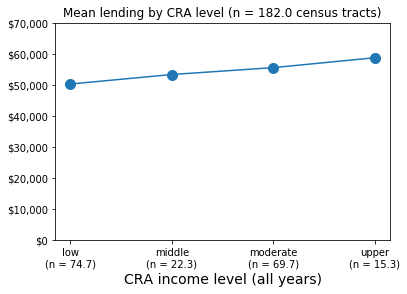

CRA level,Population,SB jobs,Pct white,Loan amount per SB job
low,"207,952.3","7,941.1",14.1%,"$50,277"
middle,"75,634.9","8,730.4",60.0%,"$53,340"
moderate,"249,975.3","11,715.9",27.1%,"$55,553"
upper,"51,378.3","4,518.4",77.3%,"$58,737"


In [17]:
# Here's another way to do the CRA analysis: add up all tracts at each CRA level, regardless of which year or what tract...

#df.groupby(['cra_level']).size()
#df.columns.tolist()
plot_type = 'line'

cra_all_df = pandas.DataFrame(df[
    ['cra_level', 'amtWorkingLoans_adj', 'CFS01', 'pop_total', 'pop_white', 'pop_black']
][
    (df['cra_level'] != 'unknown')
    & (df['CFS01'] >= jobs_lower_limit)
    & (df['pop_total'] >= pop_lower_limit)
].groupby('cra_level').size(), columns=['nTractYears'])

cra_all_df = cra_all_df.join(
    df[
        ['cra_level', 'amtWorkingLoans_adj', 'CFS01', 'pop_total', 'pop_white', 'pop_black']
    ][
        (df['cra_level'] != 'unknown')
        & (df['CFS01'] >= jobs_lower_limit)
        & (df['pop_total'] >= pop_lower_limit)
    ].groupby('cra_level').sum()
)

# Divide by 7 to get "average" jobs, population, etc.
for x in ['nTractYears', 'CFS01', 'pop_total', 'pop_white', 'pop_black']:
    cra_all_df.loc[:, x] = cra_all_df[x] / 7

cra_all_df = cra_all_df.rename(columns={'nTractYears': 'nTracts'})
cra_all_df = cra_all_df.rename(columns={'CFS01': 'sb_jobs'})


cra_all_df = cra_all_df.assign(amtWorkingLoans_per_sbjob_adj = cra_all_df['amtWorkingLoans_adj'] / cra_all_df['sb_jobs'])
cra_all_df = cra_all_df.assign(pct_white = cra_all_df['pop_white'] / cra_all_df['pop_total'])
cra_all_df = cra_all_df.assign(pct_black = cra_all_df['pop_black'] / cra_all_df['pop_total'])

fig, ax = plt.subplots(1,1)#, figsize=(48*scale, 36*scale))

label_list = cra_all_df.index.tolist()
for i in range(0, len(label_list)):
    label_list[i] += '\n(n = {0:,.1f})'.format(cra_all_df['nTracts'].loc[label_list[i]])

if (plot_type == 'line'):
    cra_all_df.plot(y='amtWorkingLoans_per_sbjob_adj', ax=ax, # yerr='sem_working_loans_per_job_adj', 
                     marker='.', ms=20)#, capsize=6, ecolor='black')
    plt.xticks(np.arange(0,4), label_list)
elif (plot_type == 'bar'):
    cra_all_df.plot.bar(y='amtWorkingLoans_per_sbjob_adj', ax=ax, #yerr='sem_working_loans_per_job_adj',
                       )#capsize=6, ecolor='black')
    plt.xticks(np.arange(0,4), label_list, rotation='horizontal')
else:
    print('Please select bar or line graph!')
    
plt.xlabel('CRA income level (all years)', fontsize=14)


yticks = np.arange(0,80000,10000)
yticklabels = ['${0:,.0f}'.format(x) for x in yticks]
plt.yticks(yticks, yticklabels)#, fontsize=44*scale)

ax.get_legend().remove()
plt.title('Mean lending by CRA level (n = {0:.1f} census tracts)'.format(cra_all_df['nTracts'].sum()))
plt.show()


htmlString = '\n\n'
htmlString += '<table>'
htmlString += '<tr><th>CRA level</th><th>Population</th><th>SB jobs</th><th>Pct white</th><th>Loan amount per SB job</th></tr>'
for ix, thisrow in cra_all_df[['pop_total', 'sb_jobs', 'pct_white', 'amtWorkingLoans_per_sbjob_adj']].iterrows():
    htmlString += '<tr>'
    htmlString += '<td>{0:}</td><td>{1:,.1f}</td><td>{2:,.1f}</td><td>{3:.1%}</td><td>${4:,.0f}</td>'.format(ix, thisrow['pop_total'], thisrow['sb_jobs'], thisrow['pct_white'], thisrow['amtWorkingLoans_per_sbjob_adj'])
    htmlString += '</tr>'    
htmlString += '</table>'

display(HTML(htmlString))



## First,

Identify "tracts with high poverty" according to Chicago's definition

Identify excess race as tracts with higher percentage black than the city average (

In [18]:
print('getting from backup...')
tracts_df = tracts_df_bk

print('calculating high and low poverty tracts...')

tracts_df = tracts_df.assign(poverty_rate = tracts_df['poverty_past_12_months'] / tracts_df['poverty_status_known'])

#print('Quantiles of poverty rate in Baltimore city:')
#print('Median {0:.1%}, richest decile {1:.1%}, richest quartile {2:.1%}, poorest quartile {3:.1%}, poorest decile {4:.1%}'.format(
#    tracts_df['poverty_rate'].quantile(0.5), 
#    tracts_df['poverty_rate'].quantile(0.1), 
#    tracts_df['poverty_rate'].quantile(0.25), 
#    tracts_df['poverty_rate'].quantile(0.75), 
#    tracts_df['poverty_rate'].quantile(0.9)
#))

#print('\n')
#htmlstring = ''
#htmlstring += "<p>OK, sure, let's use Chicago's definition of high poverty as >= 10% poverty rate</p>"

tracts_df = tracts_df.assign(poverty_class = np.nan)
tracts_df.loc[tracts_df['poverty_rate'] > 0.3, 'poverty_class'] = 'much'
tracts_df.loc[tracts_df['poverty_rate'] < 0.1, 'poverty_class'] = 'little'

print('calculating excess white and excess black tracts...')
city_pct_white = tracts_df['pop_white'].sum() / tracts_df['pop_total'].sum()
city_pct_black = tracts_df['pop_black'].sum() / tracts_df['pop_total'].sum()
print('City-wide percent of white residents: {0:.0%}'.format(city_pct_white))
print('City-wide percent of black residents: {0:.0%}'.format(city_pct_black))

tracts_df = tracts_df.assign(excess_race = 'none')

tracts_df.loc[tracts_df['pct_white'] > city_pct_white, 'excess_race'] = 'white'
tracts_df.loc[tracts_df['pct_black'] > city_pct_black, 'excess_race'] = 'black'

print('Done!')

getting from backup...
calculating high and low poverty tracts...
calculating excess white and excess black tracts...
City-wide percent of white residents: 30%
City-wide percent of black residents: 64%
Done!


## Disaggregate loans per job by poverty

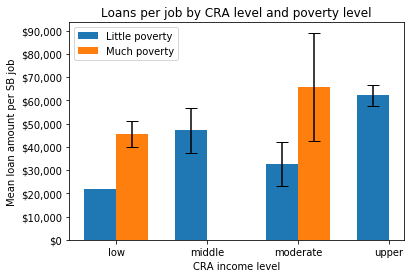

CRA level,Number ofTracts,Mean loan valueper SB job,SEM loan valueper SB job
Low,1,"$22,070",N/A
Middle,12,"$47,132","$9,785"
Moderate,6,"$32,594","$9,389"
Upper,14,"$62,113","$4,581"
CRA level,Number ofTracts,Mean loan valueper SB job,SEM loan valueper SB job
Low,44,"$45,567","$5,559"
Middle,0,N/A,N/A
Moderate,7,"$65,909","$23,189"
Upper,0,N/A,N/A


What is that weird tract with little poverty but low CRA?


census_tract,2804.02
nWorkingLoans,23
amtWorkingLoans_adj,541715
sb_jobs,23
amtWorkingLoans_per_sbjob_adj,22069.6
cra_level_2017,low
total_jobs,1088
pop_total,1657
mfi_adj,47895
pct_white,0.006035
pct_black,0.966807


In [19]:
cra_level_poverty_df = pandas.DataFrame()

cra_level_poverty_df = cra_level_poverty_df.assign(nTracts = tracts_df[
    (tracts_df['cra_level_2017'] != 'unknown')
    & (tracts_df['poverty_class'].notnull())
    & (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
].groupby(['poverty_class','cra_level_2017']).size())

cra_level_poverty_df = cra_level_poverty_df.assign(mean_amtWorkingLoans_adj_per_sbjob = tracts_df[
    (tracts_df['cra_level_2017'] != 'unknown')
    & (tracts_df['poverty_class'].notnull())
    & (tracts_df['sb_jobs'] >= jobs_lower_limit)    
    & (tracts_df['pop_total'] >= pop_lower_limit)
].groupby(['poverty_class','cra_level_2017'])['amtWorkingLoans_per_sbjob_adj'].mean())

cra_level_poverty_df = cra_level_poverty_df.assign(sem_amtWorkingLoans_adj_per_sbjob = tracts_df[
    (tracts_df['amtWorkingLoans_per_sbjob_adj'].notnull())
    & (tracts_df['cra_level_2017'] != 'unknown')
    & (tracts_df['poverty_class'].notnull())
    & (tracts_df['sb_jobs'] >= jobs_lower_limit)  
    & (tracts_df['pop_total'] >= pop_lower_limit)
].groupby(['poverty_class','cra_level_2017'])['amtWorkingLoans_per_sbjob_adj'].sem())

cra_level_poverty_df.loc[('much', 'middle'),  ['nTracts', 'mean_amtWorkingLoans_adj_per_sbjob', 'sem_amtWorkingLoans_adj_per_sbjob']] = [0, np.nan, np.nan]
cra_level_poverty_df.loc[('much', 'upper'),  ['nTracts', 'mean_amtWorkingLoans_adj_per_sbjob', 'sem_amtWorkingLoans_adj_per_sbjob']] = [0, np.nan, np.nan]
# Get into correct order for graphing
cra_level_poverty_df = cra_level_poverty_df.loc[[
    ('little', 'low'), ('little', 'middle'), ('little', 'moderate'), ('little', 'upper'), 
    ('much', 'low'), ('much', 'middle'), ('much', 'moderate'), ('much', 'upper')]]


label_sorter = np.arange(4)
width = 0.35

low_means = cra_level_poverty_df.xs('little')['mean_amtWorkingLoans_adj_per_sbjob'].tolist()
low_sems = cra_level_poverty_df.xs('little')['sem_amtWorkingLoans_adj_per_sbjob'].tolist()
high_means = cra_level_poverty_df.xs('much')['mean_amtWorkingLoans_adj_per_sbjob'].tolist()
high_sems = cra_level_poverty_df.xs('much')['sem_amtWorkingLoans_adj_per_sbjob'].tolist()

fig, ax = plt.subplots(1, 1)
plt.bar(label_sorter, low_means, width, yerr=low_sems, label='Little poverty', capsize=6)#, color='lightgray', capsize=6)
plt.bar(label_sorter+width, high_means, width, yerr=high_sems, label='Much poverty', capsize=6)#, color='lightgray', capsize=6)

plt.xticks(label_sorter + width / 2, ('low', 'middle', 'moderate', 'upper'))
yticks = np.arange(0,100000,10000)
yticklabels = ['${0:,.0f}'.format(x) for x in yticks]
plt.yticks(yticks, yticklabels)

plt.xlabel('CRA income level')
plt.ylabel('Mean loan amount per SB job')
plt.legend()
plt.title('Loans per job by CRA level and poverty level')

plt.show()

htmlString = ''
htmlString += '<p>Little poverty</p>'
htmlString += '<table>'
htmlString += '<tr><th>CRA level</th><th>Number of<br />Tracts</th><th>Mean loan value<br />per SB job</th><th>SEM loan value<br />per SB job</th></tr>'
for ix, thisrow in cra_level_poverty_df.xs('little').iterrows():
    htmlString += '<tr>'
    htmlString += '<td>{0:}</td>'.format(ix.capitalize())
    htmlString += '<td>{0:.0f}</td>'.format(thisrow['nTracts'])
    if (np.isnan(thisrow['mean_amtWorkingLoans_adj_per_sbjob'])):
        htmlString += '<td>N/A</td>'
    else:
        htmlString += '<td>${0:,.0f}</td>'.format(thisrow['mean_amtWorkingLoans_adj_per_sbjob'])
    
    if (np.isnan(thisrow['sem_amtWorkingLoans_adj_per_sbjob'])):
        htmlString += '<td>N/A</td>'
    else:
        htmlString += '<td>${0:,.0f}</td>'.format(thisrow['sem_amtWorkingLoans_adj_per_sbjob'])
    htmlString += '</tr>'
htmlString += '</table>' 

htmlString += '<p>Much poverty</p>'
htmlString += '<table>'
htmlString += '<tr><th>CRA level</th><th>Number of<br />Tracts</th><th>Mean loan value<br />per SB job</th><th>SEM loan value<br />per SB job</th></tr>'
for ix, thisrow in cra_level_poverty_df.xs('much').iterrows():
    htmlString += '<tr>'
    htmlString += '<td>{0:}</td>'.format(ix.capitalize())
    htmlString += '<td>{0:.0f}</td>'.format(thisrow['nTracts'])
    if (np.isnan(thisrow['mean_amtWorkingLoans_adj_per_sbjob'])):
        htmlString += '<td>N/A</td>'
    else:
        htmlString += '<td>${0:,.0f}</td>'.format(thisrow['mean_amtWorkingLoans_adj_per_sbjob'])
    
    if (np.isnan(thisrow['sem_amtWorkingLoans_adj_per_sbjob'])):
        htmlString += '<td>N/A</td>'
    else:
        htmlString += '<td>${0:,.0f}</td>'.format(thisrow['sem_amtWorkingLoans_adj_per_sbjob'])
    htmlString += '</tr>'
htmlString += '</table>' 
display(HTML(htmlString))


#tracts_df.head(1).T

#cra_level_poverty_df

print('What is that weird tract with little poverty but low CRA?')




tracts_df[['nWorkingLoans', 'amtWorkingLoans_adj', 'sb_jobs', 'amtWorkingLoans_per_sbjob_adj',
  'cra_level_2017', 'total_jobs', 'pop_total', 'mfi_adj', 'pct_white', 'pct_black',
  'pct_poverty', 'poverty_rate', 'poverty_class', 'excess_race']][(tracts_df['poverty_class'] == 'little') & (tracts_df['cra_level_2017'] == 'low')].T

## Disaggregate loans per job by race

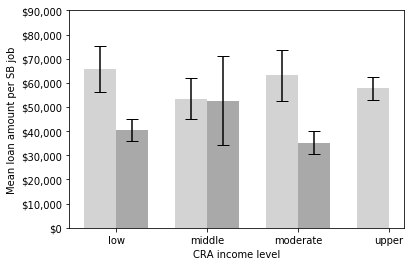

CRA level,Number ofTracts,Mean loan valueper SB job,SEM loan valueper SB job
Low,12,"$65,786","$9,616"
Middle,22,"$53,354","$8,477"
Moderate,19,"$63,118","$10,500"
Upper,17,"$57,823","$4,740"
CRA level,Number ofTracts,Mean loan valueper SB job,SEM loan valueper SB job
Low,57,"$40,430","$4,567"
Middle,3,"$52,682","$18,402"
Moderate,40,"$35,222","$4,846"
Upper,0,N/A,N/A


In [20]:
cra_level_race_df = pandas.DataFrame()

cra_level_race_df = cra_level_race_df.assign(nTracts = tracts_df[
    (tracts_df['cra_level_2017'] != 'unknown')
    & (tracts_df['excess_race'] != 'none')
    & (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
].groupby(['excess_race','cra_level_2017']).size())

cra_level_race_df = cra_level_race_df.assign(mean_amtWorkingLoans_adj_per_sbjob = tracts_df[
    (tracts_df['cra_level_2017'] != 'unknown')
    & (tracts_df['excess_race'] != 'none')
    & (tracts_df['sb_jobs'] >= jobs_lower_limit)    
    & (tracts_df['pop_total'] >= pop_lower_limit)
].groupby(['excess_race','cra_level_2017'])['amtWorkingLoans_per_sbjob_adj'].mean())

cra_level_race_df = cra_level_race_df.assign(sem_amtWorkingLoans_adj_per_sbjob = tracts_df[
    (tracts_df['amtWorkingLoans_per_sbjob_adj'].notnull())
    & (tracts_df['cra_level_2017'] != 'unknown')
    & (tracts_df['excess_race'] != 'none')
    & (tracts_df['sb_jobs'] >= jobs_lower_limit)  
    & (tracts_df['pop_total'] >= pop_lower_limit)
].groupby(['excess_race','cra_level_2017'])['amtWorkingLoans_per_sbjob_adj'].sem())

cra_level_race_df.loc[('black', 'upper'),  ['nTracts', 'mean_amtWorkingLoans_adj_per_sbjob', 'sem_amtWorkingLoans_adj_per_sbjob']] = [0, np.nan, np.nan]
#cra_level_race_df = cra_level_race_df.reset_index()

label_sorter = np.arange(4)
width = 0.35

white_means = cra_level_race_df.xs('white')['mean_amtWorkingLoans_adj_per_sbjob'].tolist()
white_sems = cra_level_race_df.xs('white')['sem_amtWorkingLoans_adj_per_sbjob'].tolist()
black_means = cra_level_race_df.xs('black')['mean_amtWorkingLoans_adj_per_sbjob'].tolist()
black_sems = cra_level_race_df.xs('black')['sem_amtWorkingLoans_adj_per_sbjob'].tolist()

plt.bar(label_sorter, white_means, width, yerr=white_sems, label='White', color='lightgray', capsize=6)
plt.bar(label_sorter+width, black_means, width, yerr=black_sems, label='Black', color='darkgray', capsize=6)

plt.xticks(label_sorter + width / 2, ('low', 'middle', 'moderate', 'upper'))
yticks = np.arange(0,100000,10000)
yticklabels = ['${0:,.0f}'.format(x) for x in yticks]
plt.yticks(yticks, yticklabels)

plt.xlabel('CRA income level')
plt.ylabel('Mean loan amount per SB job')

plt.show()

htmlString = ''
htmlString += '<p>White</p>'
htmlString += '<table>'
htmlString += '<tr><th>CRA level</th><th>Number of<br />Tracts</th><th>Mean loan value<br />per SB job</th><th>SEM loan value<br />per SB job</th></tr>'
for ix, thisrow in cra_level_race_df.xs('white').iterrows():
    htmlString += '<tr>'
    htmlString += '<td>{0:}</td>'.format(ix.capitalize())
    htmlString += '<td>{0:.0f}</td>'.format(thisrow['nTracts'])
    htmlString += '<td>${0:,.0f}</td>'.format(thisrow['mean_amtWorkingLoans_adj_per_sbjob'])
    htmlString += '<td>${0:,.0f}</td>'.format(thisrow['sem_amtWorkingLoans_adj_per_sbjob'])
    htmlString += '</tr>'
htmlString += '</table>' 

htmlString += '<p>Black</p>'
htmlString += '<table>'
htmlString += '<tr><th>CRA level</th><th>Number of<br />Tracts</th><th>Mean loan value<br />per SB job</th><th>SEM loan value<br />per SB job</th></tr>'
for ix, thisrow in cra_level_race_df.xs('black').iterrows():
    htmlString += '<tr>'
    htmlString += '<td>{0:}</td>'.format(ix.capitalize())
    htmlString += '<td>{0:.0f}</td>'.format(thisrow['nTracts'])
    if (np.isnan(thisrow['mean_amtWorkingLoans_adj_per_sbjob'])):
        htmlString += '<td>N/A</td>'
    else:
        htmlString += '<td>${0:,.0f}</td>'.format(thisrow['mean_amtWorkingLoans_adj_per_sbjob'])
    
    if (np.isnan(thisrow['sem_amtWorkingLoans_adj_per_sbjob'])):
        htmlString += '<td>N/A</td>'
    else:
        htmlString += '<td>${0:,.0f}</td>'.format(thisrow['sem_amtWorkingLoans_adj_per_sbjob'])
    htmlString += '</tr>'
htmlString += '</table>' 
display(HTML(htmlString))
#tracts_df.head(1).T

# Chicago Figure 2

## First, operationalize "high poverty" and "low poverty"

Sure, let's use Chicago's definition.

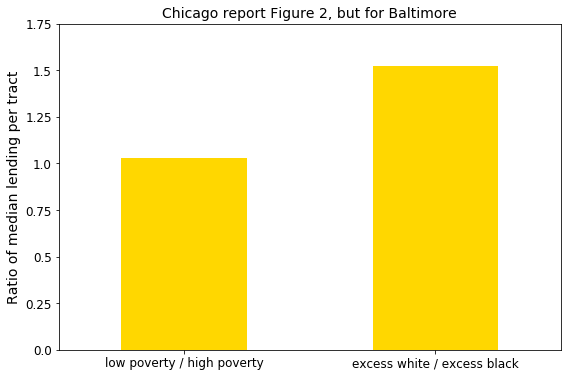

In [21]:
htmlstring = ''
htmlstring += '<table>'
htmlstring += '<tr><th>Poverty class</th><th>Number of tracts</th><th>Mean loan amount<br />per small business job</th><th>Standard error<br />of the mean</th></tr>'
htmlstring += '<tr><td>{0:}</td><td>{1:.0f}</td><td>${2:,.0f}</td><td>${3:,.0f}</tr>'.format(
    'Low poverty', 
    len(tracts_df[(tracts_df['poverty_class'] == 'little') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)]), 
    tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['poverty_class'] == 'little') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)].mean(),
    tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['poverty_class'] == 'little') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)].sem())
htmlstring += '<tr><td>{0:}</td><td>{1:.0f}</td><td>${2:,.0f}</td><td>${3:,.0f}</td></tr>'.format(
    'High poverty', 
    len(tracts_df[(tracts_df['poverty_class'] == 'much') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)]), 
    tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['poverty_class'] == 'much') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)].mean(), 
    tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['poverty_class'] == 'much') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)].sem()
)
htmlstring += '<tr><td>{0:}</td><td>-</td><td>{1:.2f}</td><td>-</td>'.format('Low / High', 
                                                      tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['poverty_class'] == 'little') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)].mean() / 
                                                      tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['poverty_class'] == 'much') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)].mean()
                                                     )
htmlstring += '</table>'


htmlstring += '<table>'
htmlstring += '<tr><th>Excess Race</th><th>Number of tracts</th><th>Mean loan amount<br />per small business job</th><th>Standard error<br />of the mean</th></tr>'
htmlstring += '<tr><td>{0:}</td><td>{1:.0f}</td><td>${2:,.0f}</td><td>${3:,.0f}</td></tr>'.format(
    'White', 
    len(tracts_df[(tracts_df['excess_race'] == 'white') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)]),  
    tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['excess_race'] == 'white') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)].mean(),
    tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['excess_race'] == 'white') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)].sem()
)
htmlstring += '<tr><td>{0:}</td><td>{1:.0f}</td><td>${2:,.0f}</td><td>${3:,.0f}</td></tr>'.format(
    'Black', 
    len(tracts_df[(tracts_df['excess_race'] == 'black') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)]),  
    tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['excess_race'] == 'black') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)].mean(), 
    tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['excess_race'] == 'black') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)].sem()
)
htmlstring += '<tr><td>{0:}</td><td>-</td><td>{1:.2f}</td><td>-</td>'.format('White / Black', 
                                                    tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['excess_race'] == 'white') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)].mean() /
                                                    tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['excess_race'] == 'black') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)].mean()
                                                   )
htmlstring += '</table>'



bar_chart_df = pandas.DataFrame(data=None, columns=['mean_loan_amt_per_sbjob'])
bar_chart_df.loc['low poverty / high poverty', 'mean_loan_amt_per_sbjob'] = (tracts_df['amtWorkingLoans_per_sbjob_adj'][tracts_df['poverty_class'] == 'little'].mean() / tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['poverty_class'] == 'much') & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)].mean())
bar_chart_df.loc['excess white / excess black', 'mean_loan_amt_per_sbjob'] = (tracts_df['amtWorkingLoans_per_sbjob_adj'][tracts_df['excess_race'] == 'white'].mean() / tracts_df['amtWorkingLoans_per_sbjob_adj'][(tracts_df['excess_race'] == 'black')  & (tracts_df['sb_jobs'] >= jobs_lower_limit) & (tracts_df['pop_total'] >= pop_lower_limit)].mean())

fig, ax = plt.subplots(1,1, figsize=(36*scale, 24*scale))
bar_chart_df.plot.bar(ax=ax, color='gold')

plt.xticks(np.arange(0,2), bar_chart_df.index.values, rotation='horizontal', fontsize=48*scale)

plt.ylabel('Ratio of median lending per tract', fontsize=56*scale)
plt.yticks(np.arange(0, 2, 0.25), np.arange(0, 2, 0.25), fontsize=48*scale)

plt.title('Chicago report Figure 2, but for Baltimore', fontsize=56*scale)
ax.get_legend().remove()

#plt.savefig(figdir+'chicago_figure2.jpg', format='jpg')
#print('Done!')

display(HTML(htmlstring))
#bar_chart_df
plt.show()


# Linear model fits: loan amounts by race and MFI

(Linear model fits are also called "regressions," but fuck Francis Galton)

Now let's forget about CRA's level classification and look directly at MFI and race as IVs, fitting the DV of loan amounts per small business job

### With variable-sized points representing number of jobs in each tract

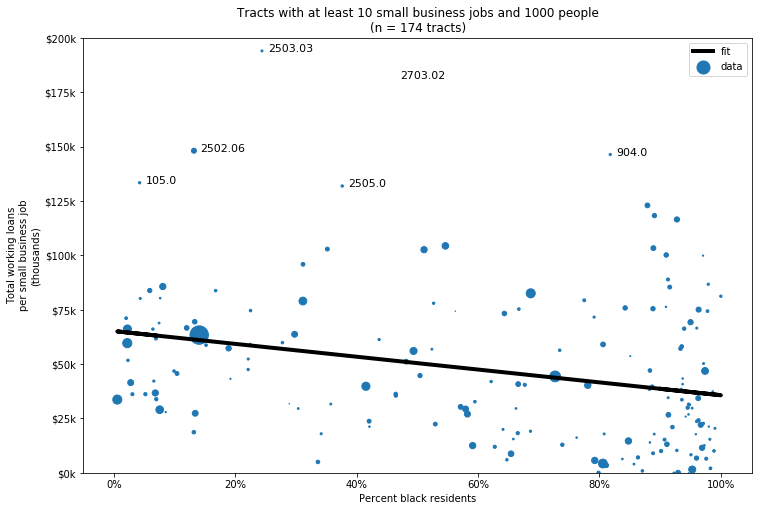

Linear model fit: amtWorkingLoans_adj_per_sb_job = -$295 * pct_black + $65,194 (r^2 = 0.078)


In [61]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    tracts_df['pct_black'][
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
    ].apply(lambda x: x * 100).values, 
    tracts_df['amtWorkingLoans_per_sbjob_adj'][
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
    ].values
)

fig, (ax1) = plt.subplots(1,1, figsize=(12,8))
siz = tracts_df['sb_jobs'].apply(lambda x: x/10).tolist()

ax1.scatter(tracts_df[
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
    ]['pct_black'], 
                tracts_df[
                    (tracts_df['sb_jobs'] >= jobs_lower_limit) 
                    & (tracts_df['pop_total'] >= pop_lower_limit)
                ]['amtWorkingLoans_per_sbjob_adj'], s=siz)

ax1.plot(tracts_df[
    (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
]['pct_black'], slope*tracts_df[
    (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
]['pct_black'].apply(lambda x: x * 100) + intercept, color='black', linewidth=4)

ax1.set_xlabel('Percent black residents')
ax1.set_ylabel('Total working loans\nper small business job\n(thousands)')

xticks = np.arange(0, 1.2, 0.2)
xlabels = ['{0:.0%}'.format(x) for x in xticks]
plt.xticks(xticks, xlabels)

plt.ylim([0, 200000])
yticks = np.arange(0, 225000, 25000)
ylabels = ['${0:.0f}k'.format(x/1000) for x in yticks]
plt.yticks(yticks, ylabels)
plt.legend(['fit', 'data'])

if (show_plot_labels):
    for ix, thisrow in tracts_df[
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
    ].iterrows():
        if (thisrow['amtWorkingLoans_per_sbjob_adj'] > 125000):
            annotator = str(ix).replace('-', '- ')
            annotator = annotator.replace('/', '/ ')
            annotator = annotator.replace(' ', '\n')
            annotator = annotator.upper()
            ax1.annotate(annotator, 
                        xy=(thisrow['pct_black'], thisrow['amtWorkingLoans_per_sbjob_adj']), fontsize=11,
                        xytext=(thisrow['pct_black'] + .01, thisrow['amtWorkingLoans_per_sbjob_adj'] - 500))

ax1.set_title('Tracts with at least {0:.0f} small business jobs and {1:.0f} people\n(n = {2:.0f} tracts)'.format(
    jobs_lower_limit, 
    pop_lower_limit, 
    len(tracts_df[
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
    ])
))

plt.show()

if (np.sign(slope) == -1):
    signsign_slope = '-'
print('Linear model fit: amtWorkingLoans_adj_per_sb_job = {0:}${1:,.0f} * pct_black + ${2:,.0f} (r^2 = {3:.3f})'.format(signsign_slope, np.abs(slope), intercept, r_value**2))


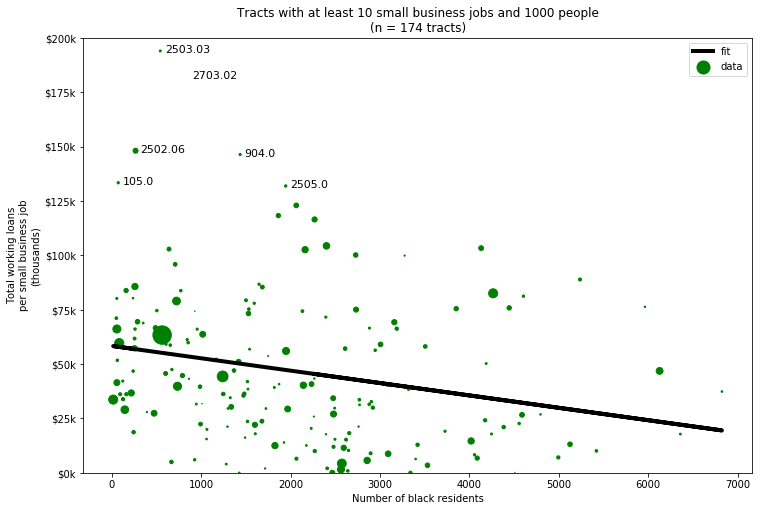

Linear model fit: amtWorkingLoans_adj_per_sb_job = -$5.70 * pop_black + $58,377 (r^2 = 0.056)


In [72]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    tracts_df['pop_black'][
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
    ].values, 
    tracts_df['amtWorkingLoans_per_sbjob_adj'][
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
    ].values
)

fig, (ax1) = plt.subplots(1,1, figsize=(12,8))
siz = tracts_df['sb_jobs'].apply(lambda x: x/10).tolist()

ax1.scatter(tracts_df[
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
    ]['pop_black'], 
                tracts_df[
                    (tracts_df['sb_jobs'] >= jobs_lower_limit) 
                    & (tracts_df['pop_total'] >= pop_lower_limit)
                ]['amtWorkingLoans_per_sbjob_adj'], s=siz, color='green')

ax1.plot(tracts_df[
    (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
]['pop_black'], slope*tracts_df[
    (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
]['pop_black'] + intercept, color='black', linewidth=4)

ax1.set_xlabel('Number of black residents')
ax1.set_ylabel('Total working loans\nper small business job\n(thousands)')

#xticks = np.arange(0, 1.2, 0.2)
#xlabels = ['{0:.0%}'.format(x) for x in xticks]
#plt.xticks(xticks, xlabels)

plt.ylim([0, 200000])
yticks = np.arange(0, 225000, 25000)
ylabels = ['${0:.0f}k'.format(x/1000) for x in yticks]
plt.yticks(yticks, ylabels)
plt.legend(['fit', 'data'])

if (show_plot_labels):
    for ix, thisrow in tracts_df[
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
    ].iterrows():
        if (thisrow['amtWorkingLoans_per_sbjob_adj'] > 125000):
            annotator = str(ix).replace('-', '- ')
            annotator = annotator.replace('/', '/ ')
            annotator = annotator.replace(' ', '\n')
            annotator = annotator.upper()
            ax1.annotate(annotator, 
                        xy=(thisrow['pop_black'], thisrow['amtWorkingLoans_per_sbjob_adj']), fontsize=11,
                        xytext=(thisrow['pop_black']+50, thisrow['amtWorkingLoans_per_sbjob_adj']-800))

ax1.set_title('Tracts with at least {0:.0f} small business jobs and {1:.0f} people\n(n = {2:.0f} tracts)'.format(
    jobs_lower_limit, 
    pop_lower_limit, 
    len(tracts_df[
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
    ])
))

plt.show()

if (np.sign(slope) == -1):
    signsign_slope = '-'
print('Linear model fit: amtWorkingLoans_adj_per_sb_job = {0:}${1:,.2f} * pop_black + ${2:,.0f} (r^2 = {3:.3f})'.format(signsign_slope, np.abs(slope), intercept, r_value**2))


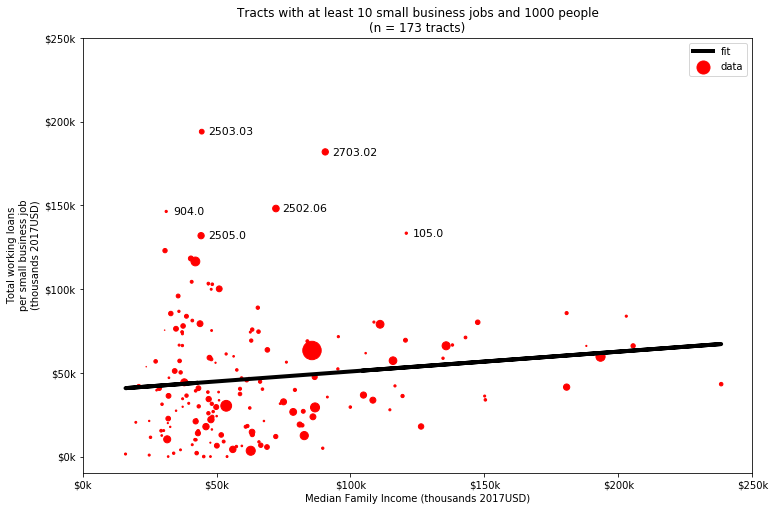

Linear model fit: mfi_adj = -0.118 * mfi_adj + $38,956 (r^2 = 0.018)


In [23]:
show_labels = True

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    tracts_df['mfi_adj'][
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
        & (tracts_df['mfi_adj'].notnull())
    ].values, 
    tracts_df['amtWorkingLoans_per_sbjob_adj'][
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
        & (tracts_df['mfi_adj'].notnull())
    ].values
)

fig, (ax1) = plt.subplots(1,1, figsize=(12,8))
siz = tracts_df['sb_jobs'].apply(lambda x: x/10).tolist()

ax1.scatter(tracts_df[
    (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
    & (tracts_df['mfi_adj'].notnull())
]['mfi_adj'], 
            tracts_df[
                (tracts_df['sb_jobs'] >= jobs_lower_limit) 
                & (tracts_df['pop_total'] >= pop_lower_limit)
                & (tracts_df['mfi_adj'].notnull())
            ]['amtWorkingLoans_per_sbjob_adj'], s=siz, color='red')

ax1.plot(tracts_df[
    (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
    & (tracts_df['mfi_adj'].notnull())
]['mfi_adj'], slope*tracts_df[
    (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
    & (tracts_df['mfi_adj'].notnull())
]['mfi_adj'] + intercept, color='black', linewidth=4)

ax1.set_xlabel('Median Family Income (thousands 2017USD)')
ax1.set_ylabel('Total working loans\nper small business job\n(thousands 2017USD)')

xticks = np.arange(0, 300000, 50000)
xlabels = ['${0:.0f}k'.format(x/1000) for x in xticks]
plt.xticks(xticks, xlabels)

#plt.ylim([0, 200000])
yticks = np.arange(0, 300000, 50000)
ylabels = ['${0:.0f}k'.format(x/1000) for x in yticks]
plt.yticks(yticks, ylabels)
plt.legend(['fit', 'data'])

if (show_labels):
    for ix, thisrow in tracts_df[
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
        & (tracts_df['mfi_adj'].notnull())
    ].iterrows():
        if (thisrow['amtWorkingLoans_per_sbjob_adj'] > 125000):
            annotator = str(ix).replace('-', '- ')
            annotator = annotator.replace('/', '/ ')
            annotator = annotator.replace(' ', '\n')
            annotator = annotator.upper()
            ax1.annotate(annotator, 
                        xy=(thisrow['mfi_adj'], thisrow['amtWorkingLoans_per_sbjob_adj']), fontsize=11,
                        xytext=(thisrow['mfi_adj'] + 2500, thisrow['amtWorkingLoans_per_sbjob_adj'] - 2000))

ax1.set_title('Tracts with at least {0:.0f} small business jobs and {1:.0f} people\n(n = {2:.0f} tracts)'.format(
    jobs_lower_limit, 
    pop_lower_limit, 
    len(tracts_df[
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
        & (tracts_df['mfi_adj'].notnull())
    ])
))

plt.show()

if (np.sign(slope) == -1):
    signsign_slope = '-'
print('Linear model fit: mfi_adj = {0:}{1:.3f} * mfi_adj + ${2:,.0f} (r^2 = {3:.3f})'.format(signsign_slope, np.abs(slope), intercept, r_value**2))


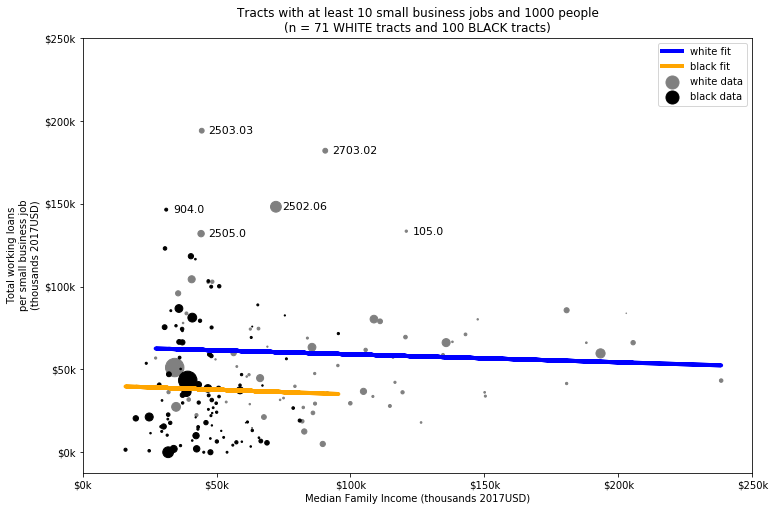

Linear model fit: mfi_adj = -0.048 * mfi_adj + $63,894 (r^2 = 0.004)
Linear model fit: mfi_adj = -0.057 * mfi_adj + $40,597 (r^2 = 0.001)


In [24]:
show_labels = True

slopew, interceptw, r_valuew, p_valuew, std_errw = scipy.stats.linregress(
    tracts_df['mfi_adj'][
        (tracts_df['excess_race'] == 'white')
        & (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
        & (tracts_df['mfi_adj'].notnull())
    ].values, 
    tracts_df['amtWorkingLoans_per_sbjob_adj'][
        (tracts_df['excess_race'] == 'white')
        & (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
        & (tracts_df['mfi_adj'].notnull())
    ].values
)

slopeb, interceptb, r_valueb, p_valueb, std_errb = scipy.stats.linregress(
    tracts_df['mfi_adj'][
        (tracts_df['excess_race'] == 'black')
        & (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
        & (tracts_df['mfi_adj'].notnull())
    ].values, 
    tracts_df['amtWorkingLoans_per_sbjob_adj'][
        (tracts_df['excess_race'] == 'black')
        & (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
        & (tracts_df['mfi_adj'].notnull())
    ].values
)

fig, (ax1) = plt.subplots(1,1, figsize=(12,8))
siz = tracts_df['sb_jobs'].apply(lambda x: x/10).tolist()

ax1.scatter(tracts_df[
    (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['excess_race'] == 'white')
    & (tracts_df['pop_total'] >= pop_lower_limit)
    & (tracts_df['mfi_adj'].notnull())
]['mfi_adj'], 
            tracts_df[
                (tracts_df['excess_race'] == 'white')
                & (tracts_df['sb_jobs'] >= jobs_lower_limit) 
                & (tracts_df['pop_total'] >= pop_lower_limit)
                & (tracts_df['mfi_adj'].notnull())
            ]['amtWorkingLoans_per_sbjob_adj'], s=siz, color='gray')

ax1.scatter(tracts_df[
    (tracts_df['excess_race'] == 'black')
    & (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
    & (tracts_df['mfi_adj'].notnull())
]['mfi_adj'], 
            tracts_df[
                (tracts_df['excess_race'] == 'black')
                & (tracts_df['sb_jobs'] >= jobs_lower_limit) 
                & (tracts_df['pop_total'] >= pop_lower_limit)
                & (tracts_df['mfi_adj'].notnull())
            ]['amtWorkingLoans_per_sbjob_adj'], s=siz, color='black')

ax1.plot(tracts_df[
    (tracts_df['excess_race'] == 'white')
    & (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
    & (tracts_df['mfi_adj'].notnull())
]['mfi_adj'], slopew*tracts_df[
    (tracts_df['excess_race'] == 'white')
    & (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
    & (tracts_df['mfi_adj'].notnull())
]['mfi_adj'] + interceptw, color='blue', linewidth=4)

ax1.plot(tracts_df[
    (tracts_df['excess_race'] == 'black')
    & (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
    & (tracts_df['mfi_adj'].notnull())
]['mfi_adj'], slopeb*tracts_df[
    (tracts_df['excess_race'] == 'black')
    & (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
    & (tracts_df['mfi_adj'].notnull())
]['mfi_adj'] + interceptb, color='orange', linewidth=4)

ax1.set_xlabel('Median Family Income (thousands 2017USD)')
ax1.set_ylabel('Total working loans\nper small business job\n(thousands 2017USD)')

ax1.set_xlabel('Median Family Income (thousands 2017USD)')
ax1.set_ylabel('Total working loans\nper small business job\n(thousands 2017USD)')

xticks = np.arange(0, 300000, 50000)
xlabels = ['${0:.0f}k'.format(x/1000) for x in xticks]
plt.xticks(xticks, xlabels)

#plt.ylim([0, 200000])
yticks = np.arange(0, 300000, 50000)
ylabels = ['${0:.0f}k'.format(x/1000) for x in yticks]
plt.yticks(yticks, ylabels)
plt.legend(['white fit', 'black fit', 'white data', 'black data'])

if (show_labels):
    for ix, thisrow in tracts_df[
        (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
        & (tracts_df['mfi_adj'].notnull())
    ].iterrows():
        if (thisrow['amtWorkingLoans_per_sbjob_adj'] > 125000):
            annotator = str(ix).replace('-', '- ')
            annotator = annotator.replace('/', '/ ')
            annotator = annotator.replace(' ', '\n')
            annotator = annotator.upper()
            ax1.annotate(annotator, 
                        xy=(thisrow['mfi_adj'], thisrow['amtWorkingLoans_per_sbjob_adj']), fontsize=11,
                        xytext=(thisrow['mfi_adj'] + 2500, thisrow['amtWorkingLoans_per_sbjob_adj'] - 2000))

ax1.set_title('Tracts with at least {0:.0f} small business jobs and {1:.0f} people\n(n = {2:.0f} WHITE tracts and {3:.0f} BLACK tracts)'.format(
    jobs_lower_limit, 
    pop_lower_limit, 
    len(tracts_df[
        (tracts_df['excess_race'] == 'white')
        & (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
        & (tracts_df['mfi_adj'].notnull())
    ]),
    len(tracts_df[
        (tracts_df['excess_race'] == 'black')
        & (tracts_df['sb_jobs'] >= jobs_lower_limit)
        & (tracts_df['pop_total'] >= pop_lower_limit)
        & (tracts_df['mfi_adj'].notnull())
    ])

))

plt.show()

if (np.sign(slopew) == -1):
    signsign_slopew = '-'
if (np.sign(slopeb) == -1):
    signsign_slopeb = '-'

print('Linear model fit: mfi_adj = {0:}{1:.3f} * mfi_adj + ${2:,.0f} (r^2 = {3:.3f})'.format(signsign_slopew, np.abs(slopew), interceptw, r_valuew**2))
print('Linear model fit: mfi_adj = {0:}{1:.3f} * mfi_adj + ${2:,.0f} (r^2 = {3:.3f})'.format(signsign_slopeb, np.abs(slopeb), interceptb, r_valueb**2))

